## Import Packages Etc

In [1]:
from IPython.display import display, HTML, Image

from sklearn.base import BaseEstimator, ClassifierMixin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
import itertools
import collections

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
import inspect
import sys
import copy

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier

# Add more packages as required

%matplotlib inline


## Do Grid Search for 6 base estimators and then use the best params for the SuperLearner

In [14]:
# Performing Grid search for the 6 base estimators for Fashion MNIST train dataset 1% sample,
# so that those parameters can be used as a sensible default set of hyper-parameters
data_sampling_rate = 0.01
cv_folds=2
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly

X = dataset[dataset.columns[1:]].values
X = X/255
Y = np.array(dataset["label"])
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, stratify=Y, test_size=0.2)

param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [25,50]}

# Perform the search
my_tuned_tree = GridSearchCV(DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, \
                            return_train_score=True)
my_tuned_tree.fit(X_train, Y_train)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
display(my_tuned_tree.best_score_)


param_grid = [
 {'n_estimators': list(range(100, 501, 50)), 'max_features': list(range(2, 10, 2)), 'min_samples_split': [25, 50] }
]

# Perform the search
my_tuned_model = GridSearchCV(RandomForestClassifier(), param_grid, cv=cv_folds)
my_tuned_model.fit(X_train, Y_train)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
print(my_tuned_model.best_score_)

param_grid = [
 {'multi_class': ['ovr'], 
 'C': [x / 10.0 for x in range(2, 21, 2)],
 'solver':['liblinear'],
  'max_iter':[1000]}
]

# Perform the search
my_tuned_model = GridSearchCV(LogisticRegression(), param_grid, cv=cv_folds)
my_tuned_model.fit(X_train, Y_train)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
print(my_tuned_model.best_score_)


param_grid = [
               {'n_neighbors': list(range(1, 50, 5))}
]

# Perform the search
my_tuned_model = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv_folds)
my_tuned_model.fit(X_train, Y_train)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
print(my_tuned_model.best_score_)

param_grid = [
               {'hidden_layer_sizes': [(400), (400, 200), (400, 200, 100)], 
               'alpha': list(10.0 ** -np.arange(1, 7))}
]

# Perform the search
my_tuned_model = GridSearchCV(MLPClassifier(), param_grid, cv=cv_folds)
my_tuned_model.fit(X_train, Y_train)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
print(my_tuned_model.best_score_)

param_grid = [
               {'hidden_layer_sizes': [(400), (400, 200), (400, 200, 100)], 
               'alpha': list(10.0 ** -np.arange(1, 7))}
]


Best parameters set found on development set:


{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 25}

0.6270833333333333

Best parameters set found on development set:
{'max_features': 8, 'min_samples_split': 25, 'n_estimators': 400}
0.75
Best parameters set found on development set:
{'C': 0.2, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}
0.78125
Best parameters set found on development set:
{'n_neighbors': 6}
0.7125


/Users/jeet/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/jeet/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/jeet/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/jeet/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/jeet/anaconda/lib/python3

Best parameters set found on development set:
{'alpha': 1e-05, 'hidden_layer_sizes': (400, 200)}
0.7916666666666666


## Define Super Learner Classifier

The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/19e9/c732082706f39d2ba12845851309714db135.pdf) but the stacked ensemble idea has been around for a long time. 

Figure 1 shows a flow diagram of the Super Learner process (this is from (van der Laan et al, 2007) and the process is also described in the COMP47590 lecture "[COMP47590 2017-2018 L04 Supervised Learning Ensembles 3](https://www.dropbox.com/s/1ksx94nxtuyn4l8/COMP47590%202017-2018%20L04%20Supervised%20Learning%20Ensembles%203.pdf?raw=1)"). The base classifiers are trained and their outputs are combined along with the training dataset labels into a training set for the stack layer classifier. To avoid overfitting the generation of the stacked layer training set uses a k-fold cross validation process (described as V-fold in Figure 1). To further add variety to the base estimators a bootstrapping selection (as is used in the bagging ensemble approach).
 
![Super Learner Process Flow](SuperLearnerProcessFlow.png "Logo Title Text 1")
Figure 1: A flow diagram for the Super Learner


### Define the SuperLearnerClassifier Class

In [28]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class SuperLearnerClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    criteria : indicates whether the stacked layer classifier should be trained 
               on label outputs from the base classifiers 
               or probability outputs from the base classifiers.
    
    stacked_model : type of model to use at the stack layer
    
    base_models : list of base estimators to use
                'CART' -> Decision Tree
                'RF' -> Random Forest
                'NB' -> Naive Bayes 
                'KNN'-> K Nearest neighbour
                'LR' -> Logisitc regression
                'MLP' -> Multi-layer perceptron
    
    add_original_input : If original data is to be added to the input at the stack layer 
        
    Attributes
    ----------
    
    chosen_base_models : list of base estimator objects as chosen
    
    final_model : the final stack layer model
    
    criteria : the type of output used to train the stacked layer
    
    correlation_hash : contains predicted values of each base estimator to calculate diversity among them
    
    Notes
    -----
    

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = SuperLearnerClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    global LIST_OF_MODELS
    # This global variable contains default set of base estimators if nothing is passed as parameter
    LIST_OF_MODELS = ('CART', 'RF', 'NB', 'KNN', 'LR', 'MLP')
    
    # SuperLearner constructor takes these arguments as parameters with default values if nothing is specified
    def __init__(self, criteria = 'label', stacked_model= 'CART', base_models = LIST_OF_MODELS, add_original_input = False):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        criteria : string like, among 'label' or 'probability'
    
        stacked_model : string like, indicates type of model - according to global values from LIST_OF_MODELS
    
        base_models : array-like, list of strings indicating type of model - according to global values from LIST_OF_MODELS
    
        add_original_input : Boolean
        
        Returns
        -------
        None
        
        """          
        # Dictionary of sensible set of hyper-parameters created from previously done grid search on base estimators
        best_hyperparams_found = {'CART': DecisionTreeClassifier(criterion= 'entropy', max_depth= 6, min_samples_split= 25),\
                        'RF': RandomForestClassifier(max_features= 4, min_samples_split= 25, n_estimators= 400),\
                        'LR': LogisticRegression(C= 0.2, max_iter= 1000, multi_class= 'ovr', solver= 'liblinear'),\
                        'NB': GaussianNB(),\
                        'KNN': KNeighborsClassifier(n_neighbors= 6),\
                        'MLP': MLPClassifier(alpha= 1e-05, hidden_layer_sizes= (400, 200), solver='lbfgs', activation='logistic')}
            
        # Use this set of sensible hyper-parameters
        __stacked_model_dict__ = {'CART': best_hyperparams_found['CART'],\
                                  'LR': best_hyperparams_found['LR'],\
                                  'RF' : best_hyperparams_found['RF'], \
                                  'NB': best_hyperparams_found['NB'], \
                                  'KNN': best_hyperparams_found['KNN'], \
                                  'MLP': best_hyperparams_found['MLP']}
        
        
#         __stacked_model_dict__ = {'CART': DecisionTreeClassifier(), 'LR': LogisticRegression(), 'RF' : RandomForestClassifier(), \
#                                   'NB': GaussianNB(), 'KNN': KNeighborsClassifier(), 'MLP': MLPClassifier(solver='lbfgs')}
        
        __base_model_dict__ = copy.deepcopy(__stacked_model_dict__ )
        
        self.base_models = base_models  #This is used in cross_val_score() which clones the object
        self.stacked_model = stacked_model #This is used in cross_val_score() which clones the object

        # Exception handling to ensure correct base estimators and stacked layer model is entered
        try:
            if len(stacked_model) < 0:
                raise ValueError
            final_model = __stacked_model_dict__[stacked_model]
        except ValueError:
            print("Please enter minimum 1 stacked model estimator")
            sys.exit(0)
        except KeyError:
            print("Please enter a valid stack model among {}".format(list(__stacked_model_dict__.keys())))
            sys.exit(0)
        
        # Final stack layer model
        self.final_model = final_model
       
        try:
            if len(base_models) < 3  or len(base_models) > 10:
                raise ValueError
            chosen_base_models = [__base_model_dict__[i] for i in self.base_models]
            self.chosen_base_models = chosen_base_models # Each base estimator
        except ValueError:
            print("Please enter minimum 3 base estimators and max 10 base estimators")
            sys.exit(0) 
        except KeyError:
            print("Please enter a valid base estimators among {}".format(list(__base_model_dict__.keys())))
            sys.exit(0) 

        # Criteria - label or probability
        self.criteria = criteria
        self.add_original_input = add_original_input

        # To check diversity among base estimators
        self.correlation_hash = {}
        
    # The fit function to train a classifier
    def fit(self, X, y):
        
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """     
        
        # As described V-fold in the description of SuperLearner
        k_fold = 10

        #Split the original dataset into K folds
        split_X = np.array_split(X, k_fold)
        split_y = np.array_split(y, k_fold)
        
        stacked_list = list()
        
        for i in range(k_fold):
            # Segregating training and test set using splitted array for both X and y
            X_test = split_X[i].tolist()
            
            X_train = [ split_X[j].tolist() for j in range(k_fold) if i!= j]
            # Flattening the X_train to 1-D list
            X_train = list(itertools.chain.from_iterable(X_train))

            y_test = split_y[i].tolist()
            y_train = [ split_y[j].tolist() for j in range(k_fold) if i!= j]
            y_train = list(itertools.chain.from_iterable(y_train))

            y_pred_list = list()
            
            #Iterate for each base estimator
            for model in self.chosen_base_models:
                # Fit each base estimator
                model.fit(X_train , y_train)
                # If criteria is label use predict else predict_proba
                y_pred = model.predict(X_test) if self.criteria == "label" else model.predict_proba(X_test)
                # Append it to as list that can be used as input to the stacked layer
                y_pred_list.append(y_pred)
                
                
                # -----TASK 9 -----
                self.y = y
                if self.criteria == "label":
                    # To evaluate correlation between base estimators only in case of label outputs
                    if str(model.__class__.__name__) not in self.correlation_hash.keys():
                        self.correlation_hash[str(model.__class__.__name__)] = y_pred.tolist()
                    else:
                        self.correlation_hash[str(model.__class__.__name__)].extend(y_pred.tolist())

            
            # Using column stack on the appended list so that the input training set for stacked layer is of proper shape
            stacked_list.append(np.column_stack(y_pred_list).tolist())
        
        #Converting stacked_list to 1-D flattened list
        stacked_list = list(itertools.chain.from_iterable(stacked_list))

        if self.add_original_input:
            # Add the original input to the final list of training data for stacked layer
            stacked_list = np.column_stack((X,stacked_list)) 
        
        self.final_model.fit(stacked_list, y)
        
        for model in self.chosen_base_models:
            # Fitting each model with entire dataset
            model.fit(X,y)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        stacked_list = list()
        y_pred_list = list()
        for model in self.chosen_base_models:
            # Predict for each base estimator if criteria is label and append it to a list
            y_pred = model.predict(X) if self.criteria == "label" else model.predict_proba(X)
            y_pred_list.append(y_pred)

        # Then append the entire list as a column stack to another list to be used at the stacked layer
        stacked_list.append(np.column_stack(y_pred_list).tolist())
        stacked_list = list(itertools.chain.from_iterable(stacked_list))

        if self.add_original_input:
            # Add the original input to the final list of training data for stacked layer
            stacked_list = np.column_stack((X,stacked_list))
        
        # Finally predict at the stacked layer
        y_pred = self.final_model.predict(stacked_list)
            
        return y_pred
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        stacked_list = list()
        y_pred_list = list()
        for model in self.chosen_base_models:
            # Predict_proba for each base estimator if criteria is probability and append it to a list
            y_pred = model.predict_proba(X) if self.criteria != "label" else model.predict(X)
            y_pred_list.append(y_pred)
        
        # Then append the entire list as a column stack to another list to be used at the stacked layer
        stacked_list.append(np.column_stack(y_pred_list).tolist())
        stacked_list = list(itertools.chain.from_iterable(stacked_list))
        
        if self.add_original_input:
            # Add the original input to the final list of training data for stacked layer
            stacked_list = np.column_stack((X,stacked_list))
            
        # Finally predict_proba at the stacked layer
        y_pred = self.final_model.predict_proba(stacked_list)
            
        return y_pred
        
    
    # ------------------------------ TASK 9 ---------------------------
    """
    This function calculates Accuracy among the base estimators using accuracy metric
    and the diversity among them using Disagreement measure.
    
    It also displays the Pearson-R correlation matrix among base estimators
    and plots the pandas dataframe using a scatter matrix plot
    
    
    Calculating disagreement measure among base estimators of SuperLearner using the formula for disagreement measure
    as stated in the Paper [2].
    
    See also: [2] https://link.springer.com/content/pdf/10.1023%2FA%3A1022859003006.pdf
    """
    
    def check_accuracy(self):
        if self.criteria != "label":
            raise ValueError("Please enter only label type output in the SuperLearner")
            return
        
        print("\n******************** Accuracy (Predictive power) of each base estimator ***********")
        acc_hash = {}
        # To evaluate accuracy between base estimators
        for model_i in self.chosen_base_models:
            y_pred = self.correlation_hash[model_i.__class__.__name__]
            accuracy = metrics.accuracy_score(self.y, y_pred)
            acc_hash[model_i.__class__.__name__] = accuracy
        display(pd.Series(acc_hash))

        
    def check_diversity(self):
        """
            Calculating Disagreement measure and Pearson-R correlation measure.
            N11 - number of Test Examples correctly classified by both classifiers
            N00 - number of Test Examples incorrectly classified by both classifiers
            N10 - number of Test Examples correctly classified by 1st classifier but incorrectly by 2nd classifier
            N01 - number of Test Examples incorrectly classified by 1st classifier but correctly by 2nd classifier
            
            Disagreement measure = (N01 + N10) / (N11 + N00 + N10 + N01)
            
            Pearson R measure is calculated by using corr() function in pandas dataframe.
            
        """
        # Dataframe used for plotting y_pred values and Pearson correlation
        plot_df = pd.DataFrame()
        diversity_hash = {}
        __dict_classfier_code__ = {'DecisionTreeClassifier': 'CART', 'RandomForestClassifier': 'RF',\
                                           'GaussianNB': 'NB', 'KNeighborsClassifier': 'KNN',\
                                           'LogisticRegression':'LR', 'MLPClassifier': 'MLP'}

        try:
            # Take every combination of base estimators and calculate disagreement measure among them
            for model_i in self.chosen_base_models:
                div_list = list()
                for model_j in self.chosen_base_models:
                    y_pred1 = self.correlation_hash[model_i.__class__.__name__]
                    y_pred2 = self.correlation_hash[model_j.__class__.__name__]
                    # Store y_preds in a pandas dataframe for visualisation
                    plot_df[__dict_classfier_code__[model_i.__class__.__name__]] = y_pred1
                    plot_df[__dict_classfier_code__[model_j.__class__.__name__]] = y_pred2

                    N11, N00, N10, N01 = 0,0,0,0

                    # Calculate the disagreement rate among the base estimators
                    for i in range(len(Y_train)):
                        if Y_train[i] == y_pred1[i] and Y_train[i] == y_pred2[i]:
                            N11 += 1
                        elif Y_train[i] != y_pred1[i] and Y_train[i] != y_pred2[i]:
                            N00 += 1
                        elif Y_train[i] == y_pred1[i] and Y_train[i] != y_pred2[i]:
                            N10 += 1
                        elif Y_train[i] != y_pred1[i] and Y_train[i] == y_pred2[i]:
                            N01 += 1

                    disagreement = (N01 + N10) / (N11 + N00 + N10 + N01)
#                     print("Disagreement between %s and %s is %.2f" % (__dict_classfier_code__[model_i.__class__.__name__],__dict_classfier_code__[model_j.__class__.__name__], disagreement))
                    div_list.append(disagreement)
                
                diversity_hash[__dict_classfier_code__[model_i.__class__.__name__]] = div_list

            # Display disagreement measure among base estimators
            print("\n******************** Disagreement (Heterogenity) measure  ***********")
            display(pd.DataFrame(collections.OrderedDict(diversity_hash), index=diversity_hash.keys()))
            # Display the Pearson R correlation among base estimators
            print("\n******************** Pearson-R correlation scores ***********")
            display(plot_df.corr())
            
            # Plotting the Pandas dataframe using a scatter matrix to visualise each base estimator's target label with others
            print("\n******************** Pandas scatter plot of y_pred values for each base estimator ***********")
            pd.plotting.scatter_matrix(df, figsize=(8, 8))
            plt.show()
            
    
        except KeyError:
            print("Please fit the model OR use label outputs in the model before checking for diversity")

### Test the SuperLearnerClassifier

Perform a simple test using the SuperLearnClassifier on the Iris dataset

In [391]:
from sklearn.datasets import load_iris

# Testing the basic version of SuperLearner on IRIS dataset with both label and probability outputs
clf = SuperLearnerClassifier()
iris = load_iris()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
y_pred_proba = clf.predict_proba(iris.data)

if clf.criteria == "label":
    y_pred = clf.predict(iris.data)
    accuracy = metrics.accuracy_score(iris.target, y_pred) 
    print("Accuracy: " +  str(accuracy))
    print(metrics.classification_report(iris.target, y_pred))
    # Evaluating 10-fold CV 
    print(cross_val_score(clf, iris.data, iris.target, cv=10))
else:
    y_pred = clf.predict_proba(iris.data)
    # Evaluating 10-fold CV 
    print(cross_val_predict(clf, iris.data, iris.target, cv=10, method='predict_proba'))

Accuracy: 0.9733333333333334
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      0.92      0.96        50
          2       0.93      1.00      0.96        50

avg / total       0.98      0.97      0.97       150

[1.         0.93333333 1.         0.93333333 0.86666667 0.93333333
 0.86666667 1.         1.         1.        ]


## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [21]:
data_sampling_rate = 0.05

Setup the number of folds for all grid searches (should be 5 - 10)

In [22]:
cv_folds = 10

### Load Dataset

Load the dataset and explore it.

In [23]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
46612,0,0,0,0,0,0,0,0,0,0,...,3,0,78,36,0,0,0,0,0,0
15327,4,0,0,0,0,0,0,0,0,0,...,3,0,4,192,194,198,140,0,0,0
38074,6,0,0,3,1,1,0,0,0,50,...,132,110,80,68,2,0,3,1,1,0
18473,3,0,0,0,0,0,0,0,0,1,...,12,7,0,0,0,0,0,0,0,0
21627,0,0,0,0,0,1,0,0,0,0,...,64,73,10,0,0,0,0,0,0,0


### Pre-process & Partition Data

Perform data pre-processing and manipulation as required

In [24]:
# Add code here
# Some data visualisation
display(dataset["label"].value_counts())

if(dataset.select_dtypes(include=[np.number]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.number]).describe())
if(dataset.select_dtypes(include=[np.object]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.object]).describe())

X = dataset[dataset.columns[1:]].values
X = X/255
Y = np.array(dataset["label"])
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, stratify=Y, test_size=0.2)


8    322
0    319
6    308
3    307
2    304
5    303
9    297
1    283
7    279
4    278
Name: label, dtype: int64

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000
mean,4.496333,0.000667,0.003667,0.020333,0.130333,0.239000,0.461667,0.896000,2.346333,5.686000,...,35.033333,23.684667,17.620333,18.011333,22.36600,17.860000,8.844333,3.094333,0.98500,0.060667
std,2.890578,0.036515,0.083600,0.218943,3.326214,4.472495,6.104666,9.011821,14.216859,24.200977,...,58.140207,49.232901,42.738933,43.523687,50.56536,44.269218,30.205456,19.394694,10.11584,1.518471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,60.000000,12.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000
max,9.000000,2.000000,3.000000,6.000000,150.000000,166.000000,190.000000,188.000000,215.000000,242.000000,...,246.000000,236.000000,246.000000,249.000000,255.00000,235.000000,219.000000,238.000000,214.00000,56.000000


## Train and Evaluate a Simple Model

Train a Super Learner Classifier using the prepared dataset

In [26]:
# Add code here
# Enter the stacked layer model as a string

"""
    While creating the SuperLearner object, if we pass criteria="probability" then it will train stacked layer with 
    probability outputs from base estimators using SuperLearner's predict_proba method
"""
x = input("Enter the stack layer model : 'CART', 'LR', 'RF', 'NB', 'KNN', 'MLP' \n").upper().strip()
clf = SuperLearnerClassifier(stacked_model = x)
print("----Fitting the classifier using {}------".format(clf.final_model.__class__.__name__))
clf.fit(X_train, Y_train)

Enter the stack layer model : 'CART', 'LR', 'RF', 'NB', 'KNN', 'MLP' 
cart
----Fitting the classifier using DecisionTreeClassifier------


SuperLearnerClassifier(add_original_input=False,
            base_models=('CART', 'RF', 'NB', 'KNN', 'LR', 'MLP'),
            criteria='label', stacked_model='CART')

## Evaluate the trained classifier

In [27]:
# Add code here
# Using X_valid to evaluate the trained SuperLearner
y_pred = clf.predict(X_valid)
accuracy = metrics.accuracy_score(Y_valid, y_pred)
print("Accuracy: " +  str(accuracy))
# Print the classification report including Precision, Recall, F1 score and Support
print(metrics.classification_report(Y_valid, y_pred))
# Display the confusion matrix
pd.crosstab(np.array(Y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7733333333333333
             precision    recall  f1-score   support

          0       0.78      0.72      0.75        64
          1       0.90      0.95      0.92        57
          2       0.56      0.67      0.61        61
          3       0.85      0.87      0.86        61
          4       0.65      0.70      0.67        56
          5       0.87      0.90      0.89        60
          6       0.43      0.32      0.37        62
          7       0.88      0.79      0.83        56
          8       0.91      0.92      0.91        64
          9       0.87      0.92      0.89        59

avg / total       0.77      0.77      0.77       600



Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,46,1,1,3,0,0,12,0,1,0,64
1,0,54,0,0,0,0,2,0,1,0,57
2,1,1,41,2,12,0,4,0,0,0,61
3,0,2,2,53,2,0,1,0,1,0,61
4,0,0,11,1,39,0,5,0,0,0,56
5,1,0,1,0,0,54,0,1,0,3,60
6,11,2,16,2,7,0,20,1,3,0,62
7,0,0,0,0,0,7,0,44,0,5,56
8,0,0,1,1,0,0,3,0,59,0,64


## Cross Validation Experiment (Task 2)

Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier

In [28]:
# 10-fold CV performed on the trained SuperLearner
scores = cross_val_score(clf, X_train, Y_train, cv=10)
print("Cross validation scores are {}".format(scores))
print("\nMean is %f and Standard deviation is %f" % (scores.mean(), scores.std()))

Cross validation scores are [0.76734694 0.77142857 0.80327869 0.78099174 0.79079498 0.77824268
 0.80252101 0.77310924 0.77446809 0.74042553]

Mean is 0.778261 and Standard deviation is 0.017370


## Comparing the Performance of Different Stack Layer Approaches (Task 5)

Compare the performance of the ensemble when a label based stack layer training set and a probability based stack layer training set is used.

In [19]:
def show_accuracy_comparison(model_valid_accuracy_comparisons):
    plt.xlim(0, 1.0)
    _ = plt.barh(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.values()), align='center')
    _= plt.yticks(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.keys()))

------ Label with Decision tree----


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,50,0,1,3,2,0,6,0,2,0,64
1,0,54,1,1,0,0,0,0,1,0,57
2,1,1,48,1,7,0,3,0,0,0,61
3,1,2,4,51,2,0,1,0,0,0,61
4,0,1,8,5,39,0,3,0,0,0,56
5,0,1,1,0,0,52,0,3,0,3,60
6,9,1,15,2,11,0,21,0,3,0,62
7,0,0,0,0,0,5,0,48,0,3,56
8,2,0,1,2,0,0,1,0,58,0,64


------ Label with Logistic regression----


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,21,26,1,2,0,2,9,0,3,0,64
1,3,51,1,1,0,0,0,0,1,0,57
2,5,2,22,21,4,3,3,0,1,0,61
3,6,1,8,43,1,0,2,0,0,0,61
4,0,0,14,24,7,2,8,0,1,0,56
5,0,0,0,0,10,37,1,8,3,1,60
6,9,2,9,4,2,3,22,0,11,0,62
7,0,0,0,0,0,11,0,34,7,4,56
8,0,0,0,0,0,2,1,0,28,33,64


------ Probability with Decision tree----


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,43,0,0,4,0,2,12,1,2,0,64
1,0,55,1,0,0,0,1,0,0,0,57
2,2,2,28,1,16,0,11,0,1,0,61
3,0,3,2,49,1,0,5,0,1,0,61
4,1,1,14,4,31,0,5,0,0,0,56
5,0,0,0,0,0,54,0,4,0,2,60
6,9,0,11,4,13,1,24,0,0,0,62
7,0,0,0,0,0,6,0,46,0,4,56
8,2,0,3,0,0,0,1,0,58,0,64


------ Probability with Logistic Regression------


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,51,0,0,3,0,0,9,0,1,0,64
1,0,55,2,0,0,0,0,0,0,0,57
2,2,0,46,1,9,0,3,0,0,0,61
3,1,0,1,55,3,0,1,0,0,0,61
4,0,0,6,4,45,0,1,0,0,0,56
5,0,0,0,0,0,54,0,2,0,4,60
6,7,0,14,3,7,0,30,0,1,0,62
7,0,0,0,0,0,2,0,48,0,6,56
8,0,0,0,1,0,0,2,0,61,0,64


Classifier Decision Tree Label : Accuracy 0.790000
Classifier Logistic Regression Label : Accuracy 0.526667
Classifier Decision Tree Probability : Accuracy 0.735000
Classifier Logistic Regression Probability : Accuracy 0.833333


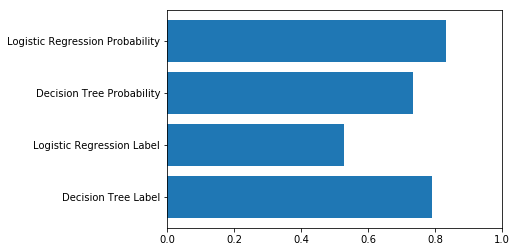

In [25]:
# Add code here
# Comparing 4 combinations of {Label, Probability} outputs with {Logistic Regression, Decision Tree} as the stacked layer model
model_valid_accuracy_comparisons = {}
clf = SuperLearnerClassifier(criteria="label")
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_valid)
accuracy = metrics.accuracy_score(Y_valid, y_pred)
print("------ Label with Decision tree----")
display(pd.crosstab(np.array(Y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
model_valid_accuracy_comparisons["Decision Tree Label"] = accuracy

clf_2 = SuperLearnerClassifier(criteria="label",stacked_model = 'LR')
clf_2.fit(X_train, Y_train)
y_pred = clf_2.predict(X_valid)
accuracy = metrics.accuracy_score(Y_valid, y_pred)
print("------ Label with Logistic regression----")
display(pd.crosstab(np.array(Y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
model_valid_accuracy_comparisons["Logistic Regression Label"] = accuracy

clf_proba = SuperLearnerClassifier(criteria="probability")
clf_proba.fit(X_train, Y_train)
y_pred = clf_proba.predict(X_valid)
accuracy = metrics.accuracy_score(Y_valid, y_pred)
print("------ Probability with Decision tree----")
display(pd.crosstab(np.array(Y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
model_valid_accuracy_comparisons["Decision Tree Probability"] = accuracy

clf_proba_2 = SuperLearnerClassifier(criteria="probability", stacked_model='LR')
clf_proba_2.fit(X_train, Y_train)
y_pred = clf_proba_2.predict(X_valid)
accuracy = metrics.accuracy_score(Y_valid, y_pred)
print("------ Probability with Logistic Regression------")
display(pd.crosstab(np.array(Y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
model_valid_accuracy_comparisons["Logistic Regression Probability"] = accuracy

#Plotting the comparison and display each one's accuracy
show_accuracy_comparison(model_valid_accuracy_comparisons)
for key, value in model_valid_accuracy_comparisons.items():
    print("Classifier %s : Accuracy %f"  % (key, value))

##  Specify the base estimators to use (Task 6)

In [34]:
""" ******* Finally the accuracy comes out to be around 81%
    when we use 6 base estimators with label outputs and stacked layer decision tree
    The 6 base estimators will be using the sensible set of hyper-parameters as was calculated initially
    using Grid Search on individual base estimators.
    The number of base estimators can vary between 3-10 as an input here.
"""
# Entering the list of base estimators to be used as a list of strings seperated by spaces
my_list = input("Enter the base estimator models (seperated by space) : 'CART', 'LR', 'RF', 'NB', 'KNN', 'MLP' \n").upper().strip()
list_of_models = my_list.split(' ')

clf = SuperLearnerClassifier(criteria="label",stacked_model = 'CART', base_models = tuple(list_of_models))
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_valid)
accuracy = metrics.accuracy_score(Y_valid, y_pred)
print("Accuracy is ", accuracy)

# cross_val_score(clf, X_train, Y_train, cv=cv_folds)


Enter the base estimator models (seperated by space) : 'CART', 'LR', 'RF', 'NB', 'KNN', 'MLP' 
CART LR RF NB KNN MLP
Accuracy is  0.8133333333333334


## Grid Search Through SuperLearnerClassifier Architectures & Parameters (Task 7)

Perfrom a grid search experiment to determine the optimal architecture and hyper-parameter values for the SuperLearnClasssifier for the MNIST Fashion classification problem.

In [8]:
# Add code here
"""  *****We find that Grid Search best accuracy comes out to be ~70%, this reduction is because we are just using 
     3 base estimators and giving 3 different combinations of those 3 estimators. Earlier we used 6 base estimators 
     and we received 81% accuracy. If we try to increase the base_models in param_grid to 5-6 estimators, grid search
     will give better accuracy and the best parameters found of the set will change accordingly.
     
     Best base estimators are found to be : Logistic regression, Random forest, K-NN which is quite good because 
     they are quite less correlated to each other so it maintains the diversity and heterogenity among base models
     in the SuperLearner.
     
     Decision Tree at the stacked layer with Label type output for base estimators are the best options as
     found by the GridSearch
"""
# ****** GRID Search on SuperLearner ******
param_grid ={'criteria': ['label','probability'], \
             'base_models': [('CART', 'KNN', 'NB'),\
                             ('LR', 'RF', 'KNN'),\
                             ('LR', 'CART', 'NB')], \
             'stacked_model': ['CART', 'LR']}
# Perform the search
my_tuned_model = GridSearchCV(SuperLearnerClassifier(), param_grid, cv=2)
my_tuned_model.fit(X_train, Y_train)

display(my_tuned_model)

print("Best parameters set found on development set:")
display(my_tuned_model.best_params_)
display(my_tuned_model.best_score_)

GridSearchCV(cv=2, error_score='raise',
       estimator=SuperLearnerClassifier(add_original_input=False,
            base_models=('CART', 'RF', 'NB', 'KNN', 'LR', 'MLP'),
            criteria='label', stacked_model='CART'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criteria': ['label', 'probability'], 'base_models': [('CART', 'KNN', 'NB'), ('LR', 'RF', 'KNN'), ('LR', 'CART', 'NB')], 'stacked_model': ['CART', 'LR']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best parameters set found on development set:


{'base_models': ('LR', 'RF', 'KNN'),
 'criteria': 'label',
 'stacked_model': 'CART'}

0.7020833333333333

Evaluate the performance of the model selected by the grid search on a hold-out dataset

In [399]:
# Add code here
#***************** Evaluating on the validation set ******************
y_pred = my_tuned_model.predict(X_valid)
accuracy = metrics.accuracy_score(Y_valid, y_pred)
print("Accuracy after Grid Search on MNIST Training set is ", accuracy)
# print(cross_val_score(my_tuned_model, X.values, Y, cv=cv_folds))


#***************** Evaluating on the Fashion MNIST Test set ******************

# LOAD the MNIST Test dataset
_test_dataset = pd.read_csv('fashion-mnist_test.csv')

X_test = _test_dataset[_test_dataset.columns[1:]].values
X_test = X_test/255
Y_test = np.array(_test_dataset["label"])
y_test_pred = my_tuned_model.predict(X_test)
accuracy_test = metrics.accuracy_score(Y_test, y_test_pred)


"""
    We conclude that after running model with best params found in Grid Search, we get an 
    accuracy of ~72%. On testing it on the MNIST test dataset, we find that accuracy is ~73%.
"""
print("Accuracy after Grid Search on MNIST Test set is ", accuracy_test)


Accuracy after Grid Search on MNIST Training set is  0.6916666666666667
Accuracy after Grid Search on MNIST Test set is  0.7041


## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer (Task 8)

Evaluate the impact of adding original descriptive features at the stack layer.

In [24]:
# Add code here
"""
    We see that after adding Original input to the Stack layer (using best parameters found from grid search),
    there is a slight reduction of accuracy(from ~74 to ~72%). This may be possible due to `curse of dimensionality`, 
    wherein the accuracy tends to fall after reaching the peak as the number of features keep increasing.
    Since the dataset itself contained 784 columns, adding it to the output of base estimators increased the
    number of features exorbitantly which resulted in drop in the accuracy of the model 
"""
# Using the best params found from Grid Search in Task 7 to evaluate the validation set
best_params_found = my_tuned_model.best_params_
criteria,stacked_model, base_models = best_params_found['criteria'], best_params_found['stacked_model'], best_params_found['base_models']
original_input_stack_model_accuracy_comparisons = {}
roc_curve = []
clf = SuperLearnerClassifier(criteria=criteria, stacked_model=stacked_model, base_models= base_models)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_valid)
accuracy = metrics.accuracy_score(Y_valid, y_pred)
original_input_stack_model_accuracy_comparisons[clf.criteria.upper() + ' ' + (clf.final_model.__class__.__name__) + ' Without Original Input'] = accuracy
print("Accuracy before adding Original Input to the Stack layer is ", accuracy)

# Now repeating the same and also adding the original input to the stack layer
clf_with_original_input = SuperLearnerClassifier(criteria=criteria,stacked_model = stacked_model, base_models = base_models, add_original_input = True)
clf_with_original_input.fit(X_train, Y_train)
y_pred = clf_with_original_input.predict(X_valid)
accuracy = metrics.accuracy_score(Y_valid, y_pred)
print("Accuracy after adding Original Input to the Stack layer is ", accuracy)
original_input_stack_model_accuracy_comparisons[clf.criteria.upper() + ' ' + (clf.final_model.__class__.__name__) + ' With Original Input'] = accuracy



Accuracy before adding Original Input to the Stack layer is  0.7383333333333333
Accuracy after adding Original Input to the Stack layer is  0.7216666666666667


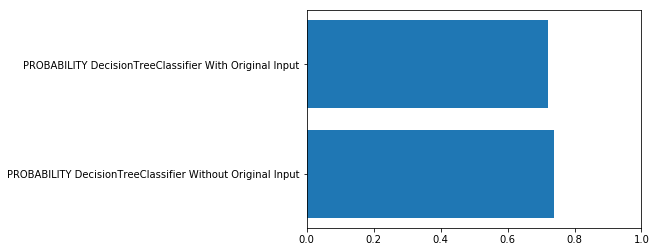

In [25]:
# Comparison of the accuracies by plotting 
show_accuracy_comparison(original_input_stack_model_accuracy_comparisons)

## Explore the Ensemble Model (Task 9)

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.


******************** Accuracy (Predictive power) of each base estimator ***********


DecisionTreeClassifier    0.699583
GaussianNB                0.506250
KNeighborsClassifier      0.778750
LogisticRegression        0.806667
MLPClassifier             0.792500
RandomForestClassifier    0.785417
dtype: float64


******************** Disagreement (Heterogenity) measure  ***********


,CART,RF,NB,KNN,LR,MLP
CART,0.000000,0.216667,0.400000,0.240000,0.234583,0.256250
RF,0.216667,0.000000,0.392500,0.165000,0.151250,0.179583
NB,0.400000,0.392500,0.000000,0.382500,0.394583,0.407083
KNN,0.240000,0.165000,0.382500,0.000000,0.167083,0.179583
LR,0.234583,0.151250,0.394583,0.167083,0.000000,0.087500
MLP,0.256250,0.179583,0.407083,0.179583,0.087500,0.000000



******************** Pearson-R correlation scores ***********


,CART,RF,NB,KNN,LR,MLP
CART,1.000000,0.803517,0.715889,0.793584,0.794191,0.770373
RF,0.803517,1.000000,0.768954,0.864027,0.870671,0.851583
NB,0.715889,0.768954,1.000000,0.764007,0.773523,0.760941
KNN,0.793584,0.864027,0.764007,1.000000,0.847583,0.836879
LR,0.794191,0.870671,0.773523,0.847583,1.000000,0.916835
MLP,0.770373,0.851583,0.760941,0.836879,0.916835,1.000000



******************** Pandas scatter plot of y_pred values for each base estimator ***********


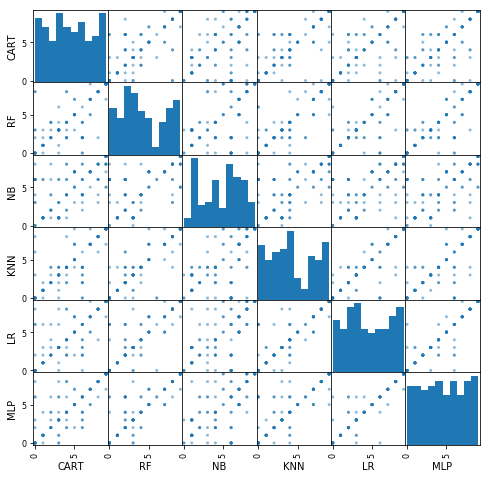

In [389]:
"""
    We calculate accuracy for each base estimator inside the SuperLearner.
    
    We can also see that Pearson correlation coefficient among all the base estimators for our SuperLearner has been
    calculated. The highest correlation is between MLP and LR (~ 93%), which is quite intuitive because Logistic regression is
    the base for Neural networks in MLP.
    
    On the other hand, the least disagreement is between NB and RF. This is again obvious, because both work on completely
    different algorithms. Random forest is an ensemble of Decision trees which is based on Predicting label outputs based
    on criterion such as entropy or gini; whereas Naive Bayes calculates the conditional probability and its 
    working is very much different from decision tree/random forest.
    
    We also found this during our grid search that combination of LR, RF and KNN in the base estimator gives best 
    accuracy, which proves that the base estimators should be properly trade-off between predictive power(accuracy)
    and the heterogenity (Diversity) among them.
"""

# Evaluating diversity vs accuracy in the SuperLearner using a simple default object with label type outputs
diversity_model = SuperLearnerClassifier(criteria="label")
diversity_model.fit(X_train, Y_train)
diversity_model.check_accuracy()
diversity_model.check_diversity()